# Comparing methods for SBM testing

In [1]:

import csv
import datetime
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from giskard.plot import subuniformity_plot
from matplotlib.transforms import Bbox
from pkg.data import load_network_palette, load_node_palette, load_unmatched
from pkg.io import FIG_PATH, get_environment_variables
from pkg.io import glue as default_glue
from pkg.io import savefig
from pkg.plot import SmartSVG, set_theme
from pkg.stats import binom_2samp, stochastic_block_test
from scipy.stats import beta, binom, chi2
from scipy.stats import combine_pvalues as scipy_combine_pvalues
from scipy.stats import ks_1samp, uniform
from svgutils.compose import Figure, Panel, Text


_, RERUN_SIMS, DISPLAY_FIGS = get_environment_variables()


FILENAME = "revamp_sbm_methods_sim"

FIG_PATH = FIG_PATH / FILENAME


def glue(name, var, **kwargs):
    default_glue(name, var, FILENAME, **kwargs)


def gluefig(name, fig, **kwargs):
    savefig(name, foldername=FILENAME, **kwargs)

    glue(name, fig, figure=True)

    if not DISPLAY_FIGS:
        plt.close()


t0 = time.time()
set_theme()
rng = np.random.default_rng(8888)

network_palette, NETWORK_KEY = load_network_palette()
node_palette, NODE_KEY = load_node_palette()
fisher_color = sns.color_palette("Set2")[2]
min_color = sns.color_palette("Set2")[3]
eric_color = sns.color_palette("Set2")[4]

GROUP_KEY = "simple_group"

left_adj, left_nodes = load_unmatched(side="left")
right_adj, right_nodes = load_unmatched(side="right")

left_labels = left_nodes[GROUP_KEY].values
right_labels = right_nodes[GROUP_KEY].values

Environment variables:
   RESAVE_DATA: true
   RERUN_SIMS: true
   DISPLAY_FIGS: False



In [2]:
stat, pvalue, misc = stochastic_block_test(
    left_adj,
    right_adj,
    labels1=left_labels,
    labels2=right_labels,
    method="fisher",
    combine_method="fisher",
)

## Model for simulations (alternative)
We have fit a stochastic block model to the left and right hemispheres. Say the
probabilities of group-to-group connections *on the left* are stored in the matrix
$B$, so that $B_{kl}$ is the probability of an edge from group $k$ to $l$.

Let $\tilde{B}$ be a *perturbed* matrix of probabilities. We are interested in testing
$H_0: B = \tilde{B}$ vs. $H_a: ... \neq ...$. To do so, we compare each
$H_0: B_{kl} = \tilde{B}_{kl}$ using Fisher's exact test. This results in p-values for
each $(k,l)$ comparison, $\{p_{1,1}, p_{1,2}...p_{K,K}\}$.

Now, we still are after an overall test for the equality $B = \tilde{B}$. Thus, we
need a way to combine p-values $\{p_{1,1}, p_{1,2}...p_{K,K}\}$ to get an *overall*
p-value for our test comparing the stochastic block model probabilities. One way is
Fisher's method; another is Tippett's method.

To compare how these two alternative methods of combining p-values work, we did the
following simulation:

- Let $t$ be the number of probabilities to perturb.
- Let $\delta$ represent the strength of the perturbation (see model below).
- For each trial:
   - Randomly select $t$ probabilities without replacement from the elements of $B$
   - For each of these elements, $\tilde{B}_{kl} = TN(B_{kl}, \delta B_{kl})$ where
     $TN$ is a truncated normal distribution, such that probabilities don't end up
     outside of [0, 1].
   - For each element *not* perturbed, $\tilde{B}_{kl} = B_{kl}$
   - Sample the number of edges from each block under each model. In other words, let
     $m_{kl}$ be the number of edges in the $(k,l)$-th block, and let $n_k, n_l$ be
     the number of edges in the $k$-th and $l$-th blocks, respectively. Then, we have

     $$m_{kl} \sim Binomial(n_k n_l, B_{kl})$$

     and likewise but with $\tilde{B}_{kl}$ for $\tilde{m}_{kl}$.
   - Run Fisher's exact test to generate a $p_{kl}$ for each $(k,l)$.
   - Run Fisher's or Tippett's method for combining p-values
- These trials were repeated for $\delta \in \{0.1, 0.2, 0.3, 0.4, 0.5\}$ and
$t \in \{25, 50, 75, 100, 125\}$. For each $(\delta, t)$ we ran 100 replicates of the
model/test above.

## P-values under the null

```{glue:figure} fig:revamp_sbm_methods_sim-null_distributions

Distributions of p-values under the null for each method. Dotted line indicates
the CDF of a $Uniform(0,1)$ random variable. The
p-values in the upper left of each panel is for a 1-sample KS test, where the null is
that the variable is distributed $Uniform(0,1)$ against the alternative that its CDF
is larger than that of a $Uniform(0,1)$ random variable (i.e. that it is superuniform).
Note that all methods appear empirically valid, some appear highly conservative.
```

## P-values under the alternative

In [3]:


def random_shift_pvalues(pvalues, rng=None):
    pvalues = np.sort(pvalues)  # already makes a copy
    diffs = list(pvalues[1:] - pvalues[:-1])
    if rng is None:
        rng = np.random.default_rng()
    uniform_samples = rng.uniform(size=len(diffs))
    moves = uniform_samples * diffs
    pvalues[1:] = pvalues[1:] - moves
    return pvalues


def my_combine_pvalues(pvalues, method="fisher", pad_high=0, n_resamples=100):
    pvalues = np.array(pvalues)
    # some methods use log(1 - pvalue) as part of the test statistic - thus when pvalue
    # is exactly 1 (which is possible for Fisher's exact test) we get an underfined
    # answer.
    if pad_high > 0:
        upper_lim = 1 - pad_high
        pvalues[pvalues >= upper_lim] = upper_lim

    scipy_methods = ["fisher", "pearson", "tippett", "stouffer", "mudholkar_george"]

    if method == "fisher-discrete-random":
        stat = 0
        pvalue = 0
        shifted_pvalues = []
        for i in range(n_resamples):
            shifted_pvalues = random_shift_pvalues(pvalues)
            curr_stat, curr_pvalue = scipy_combine_pvalues(
                shifted_pvalues, method="fisher"
            )
            stat += curr_stat / n_resamples
            pvalue += curr_pvalue / n_resamples
    # elif method == "pearson":  # HACK: https://github.com/scipy/scipy/pull/15452
    #     stat = 2 * np.sum(np.log1p(-pvalues))
    #     pvalue = chi2.cdf(-stat, 2 * len(pvalues))
    # elif method == "tippett":
    #     stat = np.min(pvalues)
    #     pvalue = beta.cdf(stat, 1, len(pvalues))
    elif method in scipy_methods:
        stat, pvalue = scipy_combine_pvalues(pvalues, method=method)
    elif method == "eric":
        stat, pvalue = ks_1samp(pvalues, uniform(0, 1).cdf, alternative="greater")
    elif method == "min":
        pvalue = min(pvalues.min() * len(pvalues), 1)
        stat = pvalue
    else:
        raise NotImplementedError()

    return stat, pvalue


def bootstrap_sample(counts, n_possible):
    probs = counts / n_possible
    return binom.rvs(n_possible, probs)


def compute_test_statistic(
    counts1, n_possible1, counts2, n_possible2, statistic="norm"
):
    probs1 = counts1 / n_possible1
    probs2 = counts2 / n_possible2
    if statistic == "norm":
        stat = np.linalg.norm(probs1 - probs2)
    elif statistic == "max":
        stat = np.max(np.abs(probs1 - probs2))
    elif statistic == "abs":
        stat = np.linalg.norm(probs1 - probs2, ord=1)
    return stat


def bootstrap_test(counts1, n_possible1, counts2, n_possible2, n_bootstraps=200):
    counts1 = np.array(counts1)
    n_possible1 = np.array(n_possible1)
    counts2 = np.array(counts2)
    n_possible2 = np.array(n_possible2)

    stat = compute_test_statistic(counts1, n_possible1, counts2, n_possible2)

    pooled_counts = (counts1 + counts2) / 2
    pooled_n_possible = (n_possible1 + n_possible2) / 2  # roughly correct?
    pooled_n_possible = pooled_n_possible.astype(int)
    null_stats = []
    for i in range(n_bootstraps):
        # TODO I think these should use the slightly different counts here actually
        bootstrap_counts1 = bootstrap_sample(pooled_counts, pooled_n_possible)
        bootstrap_counts2 = bootstrap_sample(pooled_counts, pooled_n_possible)
        null_stat = compute_test_statistic(
            bootstrap_counts1, pooled_n_possible, bootstrap_counts2, pooled_n_possible
        )
        null_stats.append(null_stat)
    null_stats = np.sort(null_stats)

    pvalue = (1 + (null_stats >= stat).sum()) / (1 + n_bootstraps)

    misc = {}

    return stat, pvalue, misc


def compare_individual_probabilities(counts1, n_possible1, counts2, n_possible2):
    pvalue_collection = []
    for i in range(len(counts1)):
        sub_stat, sub_pvalue = binom_2samp(
            counts1[i],
            n_possible1[i],
            counts2[i],
            n_possible2[i],
            null_ratio=1.0,
            method="fisher",
        )
        pvalue_collection.append(sub_pvalue)

    pvalue_collection = np.array(pvalue_collection)
    pvalue_collection = pvalue_collection[~np.isnan(pvalue_collection)]
    return pvalue_collection

In [4]:

save_path = Path(
    "/Users/bpedigo/JHU_code/bilateral/bilateral-connectome/results/"
    f"outputs/{FILENAME}/results.csv"
)
uncorrected_pvalue_path = Path(
    "/Users/bpedigo/JHU_code/bilateral/bilateral-connectome/results/"
    f"outputs/{FILENAME}/uncorrected_pvalues.csv"
)

fieldnames = [
    "perturb_size",
    "n_perturb",
    "sim",
    "uncorrected_pvalues",
]

combine_methods = [
    "fisher",
    "pearson",
    "tippett",
    "stouffer",
    "mudholkar_george",
    "min",
]
bootstrap_methods = ["bootstrap-norm", "bootstrap-max", "bootstrap-abs"]
methods = combine_methods + bootstrap_methods

B_base = misc["probabilities1"].values
inds = np.nonzero(B_base)
base_probs = B_base[inds]
n_possible_matrix = misc["possible1"].values
ns = n_possible_matrix[inds]

# n_null_sims = 100
n_bootstraps = 1000
n_sims = 50
n_perturb_range = np.linspace(0, 125, 6, dtype=int)
perturb_size_range = np.round(np.linspace(0, 0.5, 6), decimals=3)
print(f"Perturb sizes: {perturb_size_range}")
print(f"Perturb number range: {n_perturb_range}")
n_runs = n_sims * len(n_perturb_range) * len(perturb_size_range)
print(f"Number of runs: {n_runs}")


if RERUN_SIMS:
    t0 = time.time()
    mean_itertimes = 0
    n_time_first = 5
    progress_steps = 0.05
    progress_counter = 0
    last_progress = -0.05
    rows = []
    example_perturb_probs = {}

    with open(uncorrected_pvalue_path, "w") as f:
        f.truncate()

    with open(uncorrected_pvalue_path, "a") as f:
        writer = csv.DictWriter(f, fieldnames)
        writer.writeheader()

    for perturb_size in perturb_size_range:
        for n_perturb in n_perturb_range:
            # if (perturb_size == 0) or (n_perturb == 0):
            for sim in range(n_sims):
                itertime = time.time()

                # just a way to track progress
                progress_counter += 1
                progress_prop = progress_counter / n_runs
                if progress_prop - progress_steps > last_progress:
                    print(f"{progress_prop:.2f}")
                    last_progress = progress_prop

                # choose some elements to perturb
                perturb_probs = base_probs.copy()
                choice_indices = rng.choice(
                    len(perturb_probs), size=n_perturb, replace=False
                )

                # pertub em
                for index in choice_indices:
                    prob = base_probs[index]

                    new_prob = -1
                    while new_prob <= 0 or new_prob >= 1:
                        new_prob = rng.normal(prob, scale=prob * perturb_size)

                    perturb_probs[index] = new_prob

                # store some of the perturbed ones as examples
                if sim == 0:
                    example_perturb_probs[(perturb_size, n_perturb)] = perturb_probs

                # sample some new binomial data
                base_samples = binom.rvs(ns, base_probs)
                perturb_samples = binom.rvs(ns, perturb_probs)

                pvalue_collection = compare_individual_probabilities(
                    base_samples, ns, perturb_samples, ns
                )

                pvalue_row = {
                    "perturb_size": perturb_size,
                    "n_perturb": n_perturb,
                    "sim": sim,
                    "uncorrected_pvalues": list(pvalue_collection),
                }

                with open(uncorrected_pvalue_path, "a") as f:
                    writer = csv.DictWriter(f, fieldnames)
                    writer.writerow(pvalue_row)

                for method in methods:
                    if method in combine_methods:
                        stat, pvalue = my_combine_pvalues(
                            pvalue_collection, method=method
                        )
                    elif method in bootstrap_methods:
                        stat, pvalue, _ = bootstrap_test(
                            base_samples,
                            ns,
                            perturb_samples,
                            ns,
                            n_bootstraps=n_bootstraps,
                        )
                    row = {
                        "perturb_size": perturb_size,
                        "n_perturb": n_perturb,
                        "sim": sim,
                        "stat": stat,
                        "pvalue": pvalue,
                        "method": method,
                    }
                    rows.append(row)

                if progress_counter < n_time_first:
                    iter_elapsed = time.time() - itertime
                    mean_itertimes += iter_elapsed / n_time_first
                elif progress_counter == n_time_first:
                    projected_time = mean_itertimes * n_runs
                    projected_time = datetime.timedelta(seconds=projected_time)
                    print("---")
                    print(f"Projected time: {projected_time}")
                    print("---")

    total_elapsed = time.time() - t0

    print("Done!")
    print(f"Total experiment took: {datetime.timedelta(seconds=total_elapsed)}")
    results = pd.DataFrame(rows)
    results.to_csv(save_path)
else:
    results = pd.read_csv(save_path, index_col=0)

Perturb sizes: [0.  0.1 0.2 0.3 0.4 0.5]
Perturb number range: [  0  25  50  75 100 125]
Number of runs: 1800
0.00


/Users/bpedigo/JHU_code/bilateral/bilateral-connectome/.venv/lib/python3.9/site-packages/scipy/stats/_stats_py.py:8617: RuntimeWarning: divide by zero encountered in log1p
  statistic = 2 * np.sum(np.log1p(-pvalues))
/Users/bpedigo/JHU_code/bilateral/bilateral-connectome/.venv/lib/python3.9/site-packages/scipy/stats/_stats_py.py:8621: RuntimeWarning: divide by zero encountered in log1p
  statistic = -np.sum(np.log(pvalues)) + np.sum(np.log1p(-pvalues))


---
Projected time: 0:28:19.096928
---
0.05
0.10
0.15
0.20
0.25
0.30
0.35
0.41
0.46
0.51
0.56
0.61


/Users/bpedigo/JHU_code/bilateral/bilateral-connectome/.venv/lib/python3.9/site-packages/scipy/stats/_stats_py.py:8614: RuntimeWarning: divide by zero encountered in log
  statistic = -2 * np.sum(np.log(pvalues))
/Users/bpedigo/JHU_code/bilateral/bilateral-connectome/.venv/lib/python3.9/site-packages/scipy/stats/_stats_py.py:8621: RuntimeWarning: divide by zero encountered in log
  statistic = -np.sum(np.log(pvalues)) + np.sum(np.log1p(-pvalues))
/Users/bpedigo/JHU_code/bilateral/bilateral-connectome/.venv/lib/python3.9/site-packages/scipy/stats/_stats_py.py:8621: RuntimeWarning: invalid value encountered in double_scalars
  statistic = -np.sum(np.log(pvalues)) + np.sum(np.log1p(-pvalues))


0.66
0.71
0.76
0.81
0.86
0.91
0.96
Done!
Total experiment took: 0:33:47.115336


In [5]:

method_palette = dict(zip(methods, sns.color_palette()))

null_results = results[(results["n_perturb"] == 0) | (results["perturb_size"] == 0)]

n_methods = len(methods)
n_cols = min(n_methods, 3)
n_rows = int(np.ceil(n_methods / n_cols))
fig, axs = plt.subplots(n_rows, n_cols, squeeze=False, figsize=(n_cols * 5, n_rows * 5))

for i, method in enumerate(methods):
    ax = axs.flat[i]
    method_null_results = null_results[null_results["method"] == method]
    subuniformity_plot(
        method_null_results["pvalue"],
        ax=ax,
        color=method_palette[method],
        bins=np.linspace(0, 1, 100),
    )
    ax.set_title(method.capitalize())
plt.tight_layout()
gluefig("null_distributions", fig)

In [6]:
if RERUN_SIMS:
    fig, axs = plt.subplots(
        len(perturb_size_range), len(n_perturb_range), figsize=(20, 20), sharey=True
    )

    for i, perturb_size in enumerate(perturb_size_range):
        for j, n_perturb in enumerate(n_perturb_range):
            ax = axs[i, j]
            perturb_probs = example_perturb_probs[(perturb_size, n_perturb)]
            mask = base_probs != perturb_probs
            show_base_probs = base_probs[mask]
            show_perturb_probs = perturb_probs[mask]
            sort_inds = np.argsort(-show_base_probs)
            show_base_probs = show_base_probs[sort_inds]
            show_perturb_probs = show_perturb_probs[sort_inds]

            sns.scatterplot(
                x=np.arange(len(show_base_probs)), y=show_perturb_probs, ax=ax, s=10
            )
            sns.lineplot(
                x=np.arange(len(show_base_probs)),
                y=show_base_probs,
                ax=ax,
                linewidth=1,
                zorder=-1,
                color="orange",
            )
            ax.set(xticks=[])

    ax.set(yscale="log")

    gluefig("example_perturbations", fig)

In [7]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

lower = 1e-20
for i, perturb_size in enumerate(perturb_size_range[1:]):
    ax = axs.flat[i]
    plot_results = results[results["perturb_size"] == perturb_size]
    sns.lineplot(
        data=plot_results,
        x="n_perturb",
        y="pvalue",
        hue="method",
        style="method",
        palette=method_palette,
        ax=ax,
    )
    ax.set(yscale="log")
    ax.get_legend().remove()
    ax.axhline(0.05, color="dimgrey", linestyle=":")
    ax.axhline(0.005, color="dimgrey", linestyle="--")
    ax.set(ylabel="", xlabel="", title=f"{perturb_size}")
    ylim = ax.get_ylim()
    if ylim[0] < lower:
        ax.set_ylim((lower, 1.05))
    else:
        ax.set_ylim((ylim[0], 1.05))

handles, labels = ax.get_legend_handles_labels()

ax.annotate(
    0.05,
    xy=(ax.get_xlim()[1], 0.05),
    xytext=(30, 10),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="-"),
)
ax.annotate(
    0.005,
    xy=(ax.get_xlim()[1], 0.005),
    xytext=(30, -40),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="-"),
)
axs.flat[-1].axis("off")

[ax.set(ylabel="p-value") for ax in axs[:, 0]]
[ax.set(xlabel="Number perturbed") for ax in axs[1, :]]
axs[0, -1].set(xlabel="Number perturbed")

axs[0, 0].set_title(f"Perturbation size = {perturb_size_range[1]}")

for i, label in enumerate(labels):
    labels[i] = label.capitalize()
axs.flat[-1].legend(handles=handles, labels=labels, title="Method")

gluefig("perturbation_pvalues_lineplots", fig)

```{glue:figure} fig:revamp_sbm_methods_sim-perturbation_pvalues_lineplots

p-values under the alternative for two different methods for combining p-values:
[**Fisher's method**](https://en.wikipedia.org/wiki/Fisher%27s_method) (performed on the
*uncorrected* p-values) and Tippett's method.
The alternative is specified by changing the number of probabilities which are perturbed
(x-axis in each panel) as well as the size of the perturbations which are done
to each probability (panels show increasing perturbation size). Dotted and dashed
lines indicate significance thresholds for $\alpha = \{0.05, 0.005\}$, respectively.
Note that in this simulation, even for large numbers of small perturbations (i.e. upper
left panel), Tippett's method has smaller p-values. Fisher's method displays smaller p-values
than Tippett's only when there are many (>50) large perturbations, but by this point both
methods yield extremely small p-values.
```

## Power under the alternative

In [8]:
alpha = 0.05
results["detected"] = 0
results.loc[results[(results["pvalue"] < alpha)].index, "detected"] = 1

In [9]:
fisher_results = results[results["method"] == "fisher"]
min_results = results[results["method"] == "tippett"]

fisher_means = fisher_results.groupby(["perturb_size", "n_perturb"]).mean()
min_means = min_results.groupby(["perturb_size", "n_perturb"]).mean()

fisher_power_square = fisher_means.reset_index().pivot(
    index="perturb_size", columns="n_perturb", values="detected"
)
min_power_square = min_means.reset_index().pivot(
    index="perturb_size", columns="n_perturb", values="detected"
)

mean_diffs = fisher_means["detected"] / min_means["detected"]

mean_diffs = mean_diffs.to_frame().reset_index()

ratios_square = mean_diffs.pivot(
    index="perturb_size", columns="n_perturb", values="detected"
)

v = np.max(np.abs(mean_diffs.values))

set_theme(font_scale=1.5)
# set up plot
pad = 0.5
width_ratios = [1, pad * 1.2, 10, pad, 10, 1.3 * pad, 10, 1]
fig, axs = plt.subplots(
    1,
    len(width_ratios),
    figsize=(30, 10),
    gridspec_kw=dict(
        width_ratios=width_ratios,
    ),
)
fisher_col = 2
min_col = 4
ratio_col = 6


def shrink_axis(ax, scale=0.7):
    pos = ax.get_position()
    mid = (pos.ymax + pos.ymin) / 2
    height = pos.ymax - pos.ymin
    new_pos = Bbox(
        [
            [pos.xmin, mid - scale * 0.5 * height],
            [pos.xmax, mid + scale * 0.5 * height],
        ]
    )
    ax.set_position(new_pos)


def power_heatmap(
    data, ax=None, center=0, vmin=0, vmax=1, cmap="RdBu_r", cbar=False, **kwargs
):
    out = sns.heatmap(
        data.values[1:, 1:],
        ax=ax,
        yticklabels=perturb_size_range[1:],
        xticklabels=n_perturb_range[1:],
        square=True,
        center=center,
        vmin=vmin,
        vmax=vmax,
        cbar_kws=dict(shrink=0.7),
        cbar=cbar,
        cmap=cmap,
        **kwargs,
    )
    ax.invert_yaxis()
    return out


ax = axs[fisher_col]
im = power_heatmap(fisher_power_square, ax=ax)
ax.set_title("Fisher's method", fontsize="large")

ax = axs[0]
shrink_axis(ax, scale=0.5)
_ = fig.colorbar(
    im.get_children()[0],
    cax=ax,
    fraction=1,
    shrink=1,
    ticklocation="left",
)
ax.set_title("Power\n" + r"($\alpha=0.05$)", pad=25)

ax = axs[min_col]
power_heatmap(min_power_square, ax=ax)
ax.set_title("Tippett's method", fontsize="large")
ax.set(yticks=[])

pal = sns.diverging_palette(145, 300, s=60, as_cmap=True)

ax = axs[ratio_col]
im = power_heatmap(np.log10(ratios_square), ax=ax, vmin=-2, vmax=2, center=0, cmap=pal)
ax.set(yticks=[])

ax = axs[-1]
shrink_axis(ax, scale=0.5)
_ = fig.colorbar(
    im.get_children()[0],
    cax=ax,
    fraction=1,
    shrink=1,
    ticklocation="right",
)
ax.text(2, 1, "Fisher more\nsensitive", transform=ax.transAxes, va="top")
ax.text(2, 0.5, "Equal power", transform=ax.transAxes, va="center")
ax.text(2, 0, "Tippett's more\nsensitive", transform=ax.transAxes, va="bottom")
ax.set_title("Log10\npower\nratio", pad=20)

# remove dummy axes
for i in range(len(width_ratios)):
    if not axs[i].has_data():
        axs[i].set_visible(False)

xlabel = r"# perturbed blocks $\rightarrow$"
ylabel = r"Perturbation size $\rightarrow$"
axs[fisher_col].set(
    xlabel=xlabel,
    ylabel=ylabel,
)
axs[min_col].set(xlabel=xlabel, ylabel="")
axs[ratio_col].set(xlabel=xlabel, ylabel="")

fig.text(0.09, 0.86, "A)", fontweight="bold", fontsize=50)
fig.text(0.64, 0.86, "B)", fontweight="bold", fontsize=50)
gluefig("relative_power", fig)

/var/folders/pz/l5ltdh6x63j99hyc0cy_3pvm0000gn/T/ipykernel_95903/3279160874.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  fisher_means = fisher_results.groupby(["perturb_size", "n_perturb"]).mean()
/var/folders/pz/l5ltdh6x63j99hyc0cy_3pvm0000gn/T/ipykernel_95903/3279160874.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  min_means = min_results.groupby(["perturb_size", "n_perturb"]).mean()
/Users/bpedigo/JHU_code/bilateral/bilateral-connectome/.venv/lib/python3.9/site-packages/pandas/core/internals/blocks.py:352: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwa

In [10]:

set_theme(font_scale=1.25)


min_null_results = min_results[
    (min_results["n_perturb"] == 0) | (min_results["perturb_size"] == 0)
]

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
subuniformity_plot(min_null_results["pvalue"], ax=ax, write_pvalue=False)
ax.set_xlabel("p-value")
ax.set(title="p-values under $H_0$")
gluefig("tippett_null_cdf", fig)

In [11]:

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
out = power_heatmap(min_power_square, ax=ax, cbar=True)
xlabel = r"# perturbed blocks $(t)$ $\rightarrow$"
ylabel = r"Perturbation size $(\delta)$ $\rightarrow$"
ax.set(xlabel=xlabel, ylabel=ylabel, title="Power under $H_A $" + r"($\alpha=0.05$)")
gluefig("tippett_power_matrix", fig)

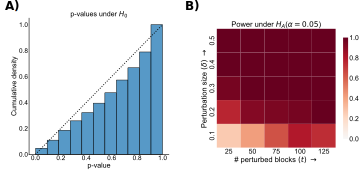

In [12]:

fontsize = 12

null = SmartSVG(FIG_PATH / "tippett_null_cdf.svg")
null.set_width(200)
null.move(10, 10)
null_panel = Panel(null, Text("A)", 5, 10, size=fontsize, weight="bold"))

power = SmartSVG(FIG_PATH / "tippett_power_matrix.svg")
power.set_width(200)
power.move(20, 20)
power_panel = Panel(power, Text("B)", 5, 10, size=fontsize, weight="bold"))
power_panel.move(null.width * 0.9, 0)

fig = Figure(null.width * 2 * 0.9, null.width * 0.9, null_panel, power_panel)
fig.save(FIG_PATH / "tippett_sim_composite.svg")
fig

```{glue:figure} fig:revamp_sbm_methods_sim-relative_power

Comparison of power for Fisher's and Tippett's method. **A)** The power under the
alternative described in the text for both Fisher's method and Tippett's method. In both
heatmaps, the x-axis represents an increasing number of blocks which are perturbed,
and the y-axis represents an increasing magnitude for each perturbation. **B)** The
log of the ratio of powers (Fisher's / Tippett's) for each alternative. Note that positive
(purple) values would represent that Fisher's is more powerful, and negative (green)
represent that Tippett's method is more powerful. Notice that Tippett's method appears
to have more power for subtler (fewer or smaller perturbations) alternatives, and
nearly equal power for more obvious alternatives.
```